# Exercise-3

> I will be using a different model `tf.keras.applications.resnet_v2.ResNet50V2` as the base model for training.

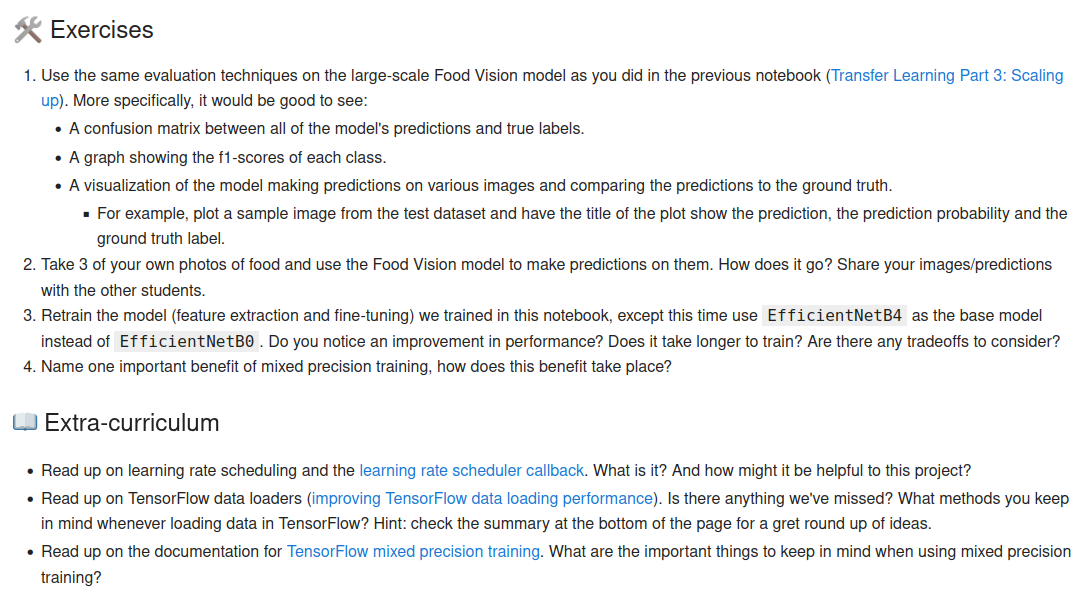

## Imports

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras import mixed_precision

import os
import random
import itertools

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

## Helper Function

In [2]:
!wget https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py

--2022-08-17 11:50:30--  https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19296 (19K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  18.84K  --.-KB/s    in 0s      

2022-08-17 11:50:30 (89.5 MB/s) - ‘helper_functions.py’ saved [19296/19296]



In [3]:
from helper_functions import unzip_data, plot_loss_curves, compare_historys, create_data_augmented_layer_for_model, load_and_prep_image, make_confusion_matrix_for_larger_dataset

## Loading the dataset

In [4]:
(train_data, test_data), ds_info= tfds.load(name="food101", split=["train", "validation"], shuffle_files=False, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteVWPY2Q/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteVWPY2Q/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [5]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='~/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo

In [6]:
class_names= ds_info.features['label'].names
len(class_names)

101

In [7]:
sample_1= train_data.take(5)
sample_1

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [8]:
for image, label in sample_1:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class or Label from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class or Label from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
        

  Image shape: (384, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class or Label from Food101 (tensor form): 76
  Class name (str form): pizza
        

  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class or Label from Food101 (tensor form): 21
  Class name (str form): chocolate_cake
        

  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class or Label from Food101 (tensor form): 64
  Class name (str form): miso_soup
        

  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class or Label from Food101 (tensor form): 10
  Class name (str form): bruschetta
        


In [9]:
image.shape

TensorShape([512, 512, 3])

## Plotting image from the dataset

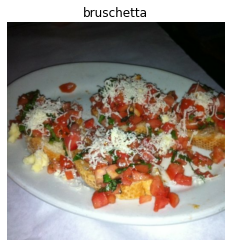

In [10]:
plt.imshow(image/255)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Preprocessing Image Function

In [11]:
from helper_functions import preprocess_image

In [12]:
processed_image, processed_label= preprocess_image(image, label)

In [13]:
processed_image

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 12.943877  ,  12.943877  ,  12.943877  ],
        [ 12.357142  ,  12.357142  ,  12.357142  ],
        [ 11.280612  ,  11.280612  ,  11.280612  ],
        ...,
        [  1.        ,   5.        ,   4.        ],
        [  0.92855835,   4.9285583 ,   3.9285583 ],
        [  0.        ,   4.        ,   3.        ]],

       [[ 11.        ,  11.        ,  11.        ],
        [ 11.        ,  11.        ,  11.        ],
        [ 11.928572  ,  11.928572  ,  11.928572  ],
        ...,
        [  1.9285717 ,   5.9285717 ,   4.9285717 ],
        [  1.        ,   5.        ,   4.        ],
        [  0.9744874 ,   4.9744873 ,   3.9744873 ]],

       [[ 13.        ,  13.        ,  13.        ],
        [ 12.801021  ,  12.801021  ,  12.801021  ],
        [ 11.954082  ,  11.954082  ,  11.954082  ],
        ...,
        [  2.        ,   6.        ,   5.        ],
        [  1.9438673 ,   5.943867  ,   4.943867  ],
        [  1.13774

In [14]:
processed_image_1, processed_label_1= preprocess_image(image, label, scaling=True)

In [15]:
processed_image_1

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.0507603 , 0.0507603 , 0.0507603 ],
        [0.04845938, 0.04845938, 0.04845938],
        [0.0442377 , 0.0442377 , 0.0442377 ],
        ...,
        [0.00392157, 0.01960784, 0.01568628],
        [0.00364141, 0.01932768, 0.01540611],
        [0.        , 0.01568628, 0.01176471]],

       [[0.04313726, 0.04313726, 0.04313726],
        [0.04313726, 0.04313726, 0.04313726],
        [0.04677871, 0.04677871, 0.04677871],
        ...,
        [0.00756303, 0.0232493 , 0.01932773],
        [0.00392157, 0.01960784, 0.01568628],
        [0.00382152, 0.01950779, 0.01558622]],

       [[0.05098039, 0.05098039, 0.05098039],
        [0.05020008, 0.05020008, 0.05020008],
        [0.04687875, 0.04687875, 0.04687875],
        ...,
        [0.00784314, 0.02352941, 0.01960784],
        [0.00762301, 0.02330928, 0.01938771],
        [0.00446176, 0.02014803, 0.01622646]],

       ...,

       [[0.62184864, 0.63361335, 0.69243693],
        [0.61

original Image
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 10
    Class name (str form): bruschetta


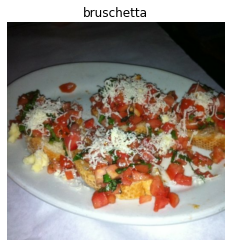

In [16]:
print("original Image")
plt.imshow(image)
plt.title(class_names[label.numpy()])
print(f"""Image shape: {image.shape} Image dtype: {image.dtype} Target class or Label from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}""")
plt.axis(False);

original Image
Image shape: (224, 224, 3) Image dtype: <dtype: 'float32'> Target class or Label from Food101 (tensor form): 10
    Class name (str form): bruschetta


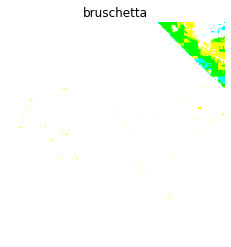

In [17]:
print("original Image")
plt.imshow(processed_image)
plt.title(class_names[processed_label.numpy()])
print(f"""Image shape: {processed_image.shape} Image dtype: {processed_image.dtype} Target class or Label from Food101 (tensor form): {processed_label}
    Class name (str form): {class_names[processed_label.numpy()]}""")
plt.axis(False);

original Image
Image shape: (224, 224, 3) Image dtype: <dtype: 'float32'> Target class or Label from Food101 (tensor form): 10
    Class name (str form): bruschetta


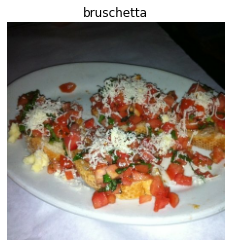

In [18]:
print("original Image")
plt.imshow(processed_image_1)
plt.title(class_names[processed_label_1.numpy()])
print(f"""Image shape: {processed_image_1.shape} Image dtype: {processed_image_1.dtype} Target class or Label from Food101 (tensor form): {processed_label_1}
    Class name (str form): {class_names[processed_label_1.numpy()]}""")
plt.axis(False);

## Creating the `train and test` dataset batches

In [19]:
train_data= train_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_data= train_data.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE) # Shuffeling the training dataset
test_data= test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [20]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Feature Extraction Model Callbacks

In [21]:
from helper_functions import  create_tensorboard_callback, model_check_point_callback, create_early_stopping_callback, reduce_learning_rate_callback

In [22]:
# Model Checkpoint Callback
checkpoint_feature_extraction= 'checkpoints/feature_extraction_model'
checkpoint_callback=model_check_point_callback(checkpoint_feature_extraction, save_weights_only=True, save_best_only=True, monitor="val_loss")

# Tensorboard Callback
tensorboard_callback= create_tensorboard_callback("transfer_learning", "101_classes_feature_extraction_all_data")

# Early Stopping Callback
early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=5)

# Learning Rate Scheduler

def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Reduce Learing Rate Callback

learning_rate_reduce_callback= reduce_learning_rate_callback(monitor="val_loss", factor=0.2, patience=2, minimum_lr=1e-7)

Saving TensorBoard log files to: transfer_learning/101_classes_feature_extraction_all_data/20220817-120132


## Augmented Layer

In [23]:
augmented_layer=create_data_augmented_layer_for_model(RandomFlip="horizontal", RandomRotation=0.2, RandomZoom=0.2, RandomHeight=0.2, RandomWidth=0.2)
augmented_layer

## Turning on Mixed Precision Training

In [24]:
mixed_precision.set_global_policy("mixed_float16")

In [25]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Feature Extraction Model

In [26]:
# Create base model
input_shape = (224, 224, 3)
CLASS_COUNT= len(class_names)
base_model = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# This is needed as we are using "ResNet50V2" as the base_model and this does not have a Rescaling layer build-in 
x = preprocessing.Rescaling(1./255)(inputs)
x= augmented_layer(x)
x = base_model(x, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x=  tf.keras.layers.Dropout(0.2, name="dropout_layer")(x) # Dropout Layer
x= layers.Dense(units= CLASS_COUNT,kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4), activity_regularizer=regularizers.L2(1e-5), name='regularization_layer')(x) # Regularization Layer
x = layers.Dense(CLASS_COUNT)(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

94683136/94668760 [==============================] - 1s 0us/step


In [27]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 pooling_layer (GlobalAverag  (None, 2048)             0         
 ePooling2D)                                                     
                                                                 
 dropout_layer (Dropout)     (None, 2048)              0     

In [28]:
for layer in base_model.layers:
  print(layer, layer.name, layer.dtype, layer.dtype_policy)

<keras.engine.input_layer.InputLayer object at 0x7f5ab7f10610> input_1 float32 <Policy "float32">
<keras.layers.convolutional.ZeroPadding2D object at 0x7f5ab3c08750> conv1_pad float32 <Policy "mixed_float16">
<keras.layers.convolutional.Conv2D object at 0x7f5ab3435e90> conv1_conv float32 <Policy "mixed_float16">
<keras.layers.convolutional.ZeroPadding2D object at 0x7f5ab7ee4b10> pool1_pad float32 <Policy "mixed_float16">
<keras.layers.pooling.MaxPooling2D object at 0x7f5ab3c08a10> pool1_pool float32 <Policy "mixed_float16">
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f5ab7edf0d0> conv2_block1_preact_bn float32 <Policy "mixed_float16">
<keras.layers.core.activation.Activation object at 0x7f5ab343f950> conv2_block1_preact_relu float32 <Policy "mixed_float16">
<keras.layers.convolutional.Conv2D object at 0x7f5ab7eda090> conv2_block1_1_conv float32 <Policy "mixed_float16">
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f5

In [29]:
for layer in model.layers:
  print(layer, layer.name, layer.dtype, layer.dtype_policy)

<keras.engine.input_layer.InputLayer object at 0x7f5ab8de4210> input_layer float32 <Policy "float32">
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f5ab3c08f10> rescaling float32 <Policy "mixed_float16">
<keras.engine.sequential.Sequential object at 0x7f5ab8117b50> data_augmentation_layer float32 <Policy "float32">
<keras.engine.functional.Functional object at 0x7f5ab8de0d10> resnet50v2 float32 <Policy "mixed_float16">
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f5ab3a60f10> pooling_layer float32 <Policy "mixed_float16">
<keras.layers.core.dropout.Dropout object at 0x7f5ab3caf790> dropout_layer float32 <Policy "mixed_float16">
<keras.layers.core.dense.Dense object at 0x7f5ab82f7f50> regularization_layer float32 <Policy "mixed_float16">
<keras.layers.core.dense.Dense object at 0x7f5ab3b1acd0> dense float32 <Policy "mixed_float16">
<keras.layers.core.activation.Activation object at 0x7f5abda62110> softmax_float32 float32 <Policy "float32">


In [30]:
history_101_food_classes_feature_extract = model.fit(train_data, epochs=10,steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.15 * len(test_data)),callbacks=[tensorboard_callback, checkpoint_callback, lr_scheduler_callback, learning_rate_reduce_callback])

Epoch 1/10
2368/2368 [==============================] - ETA: 0s - loss: 2.9696 - accuracy: 0.3210
Epoch 1: val_loss improved from inf to 2.03567, saving model to checkpoints/feature_extraction_model
2368/2368 [==============================] - 236s 92ms/step - loss: 2.9696 - accuracy: 0.3210 - val_loss: 2.0357 - val_accuracy: 0.4981 - lr: 0.0010
Epoch 2/10
2368/2368 [==============================] - ETA: 0s - loss: 2.6323 - accuracy: 0.3873
Epoch 2: val_loss did not improve from 2.03567
2368/2368 [==============================] - 193s 81ms/step - loss: 2.6323 - accuracy: 0.3873 - val_loss: 2.0499 - val_accuracy: 0.4968 - lr: 0.0010
Epoch 3/10
2368/2368 [==============================] - ETA: 0s - loss: 2.5995 - accuracy: 0.3973
Epoch 3: val_loss improved from 2.03567 to 1.98743, saving model to checkpoints/feature_extraction_model
2368/2368 [==============================] - 187s 78ms/step - loss: 2.5995 - accuracy: 0.3973 - val_loss: 1.9874 - val_accuracy: 0.5177 - lr: 0.0010
Epoch 

In [31]:
model.evaluate(test_data)

790/790 [==============================] - 49s 62ms/step - loss: 1.7880 - accuracy: 0.5694


[1.787976622581482, 0.5694257616996765]

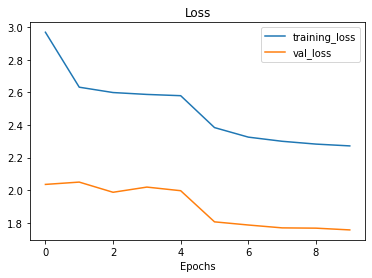

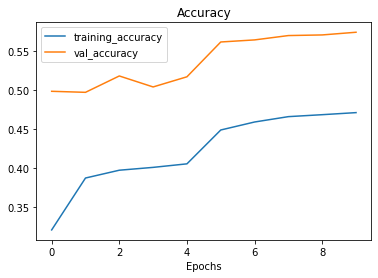

In [32]:
plot_loss_curves(history_101_food_classes_feature_extract)

In [33]:
result_feature_extraction= model.evaluate(test_data)
result_feature_extraction

790/790 [==============================] - 48s 61ms/step - loss: 1.7880 - accuracy: 0.5694


[1.787976622581482, 0.5694257616996765]

In [34]:
saved_model_dir='saved_models/model_feature_extraction_model'

In [35]:
model.save(saved_model_dir)

## Load the saved Feature Extraction Model

In [36]:
loaded_model= tf.keras.models.load_model(saved_model_dir)

In [37]:
loaded_model_result=loaded_model.evaluate(test_data)
loaded_model_result

790/790 [==============================] - 50s 61ms/step - loss: 1.7880 - accuracy: 0.5694


[1.787976622581482, 0.5694257616996765]

## Checking if the model saved/loaded correctly

In [38]:
loaded_model_result == result_feature_extraction

True

In [39]:
np.allclose(result_feature_extraction, loaded_model_result)

True

## Checking the layers of the loaded model

In [40]:
for layer in loaded_model.layers:
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f5ab455ead0> input_layer True
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f5ab6845a10> rescaling True
<keras.engine.sequential.Sequential object at 0x7f5ab666fd10> data_augmentation_layer True
<keras.engine.functional.Functional object at 0x7f5ab74a3b90> resnet50v2 False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f5a2068b1d0> pooling_layer True
<keras.layers.core.dropout.Dropout object at 0x7f5a2068b110> dropout_layer True
<keras.layers.core.dense.Dense object at 0x7f5ab76c9f10> regularization_layer True
<keras.layers.core.dense.Dense object at 0x7f5ab6995290> dense True
<keras.layers.core.activation.Activation object at 0x7f5ab757a550> softmax_float32 True


In [42]:
for layer in loaded_model.layers[3].layers:
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f5ab7714a50> input_1 True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f5ab76a4350> conv1_pad False
<keras.layers.convolutional.Conv2D object at 0x7f5ab74ac190> conv1_conv False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f5ab7669450> pool1_pad False
<keras.layers.pooling.MaxPooling2D object at 0x7f5ab69840d0> pool1_pool False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f5ab770d850> conv2_block1_preact_bn False
<keras.layers.core.activation.Activation object at 0x7f5ab778bc10> conv2_block1_preact_relu False
<keras.layers.convolutional.Conv2D object at 0x7f5ab778b450> conv2_block1_1_conv False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f5ab777e810> conv2_block1_1_bn False
<keras.layers.core.activation.Activation object at 0x7f5ab6972410> conv2_block1_1_relu False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f5ab657b890> conv2_block1_2_

## Unfreezing all the layers of the base_model i.e ResNet50V2 for Fine-Tuning

In [43]:
for layer in loaded_model.layers:
  layer.trainable= True
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f5ab455ead0> input_layer True
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f5ab6845a10> rescaling True
<keras.engine.sequential.Sequential object at 0x7f5ab666fd10> data_augmentation_layer True
<keras.engine.functional.Functional object at 0x7f5ab74a3b90> resnet50v2 True
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f5a2068b1d0> pooling_layer True
<keras.layers.core.dropout.Dropout object at 0x7f5a2068b110> dropout_layer True
<keras.layers.core.dense.Dense object at 0x7f5ab76c9f10> regularization_layer True
<keras.layers.core.dense.Dense object at 0x7f5ab6995290> dense True
<keras.layers.core.activation.Activation object at 0x7f5ab757a550> softmax_float32 True


In [46]:
for layer in loaded_model.layers[3].layers:
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f5ab7714a50> input_1 True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f5ab76a4350> conv1_pad True
<keras.layers.convolutional.Conv2D object at 0x7f5ab74ac190> conv1_conv True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f5ab7669450> pool1_pad True
<keras.layers.pooling.MaxPooling2D object at 0x7f5ab69840d0> pool1_pool True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f5ab770d850> conv2_block1_preact_bn True
<keras.layers.core.activation.Activation object at 0x7f5ab778bc10> conv2_block1_preact_relu True
<keras.layers.convolutional.Conv2D object at 0x7f5ab778b450> conv2_block1_1_conv True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f5ab777e810> conv2_block1_1_bn True
<keras.layers.core.activation.Activation object at 0x7f5ab6972410> conv2_block1_1_relu True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f5ab657b890> conv2_block1_2_pad True


In [49]:
for layer in loaded_model.layers[3].layers:
  if layer.trainable == False:
    print(layer, layer.name, layer.trainable)

In [50]:
for layer in base_model.layers:
  if layer.trainable == True:
    print(layer, layer.name)

In [51]:
len(loaded_model.layers)

9

In [52]:
len(loaded_model.trainable_variables)

176

In [53]:
len(base_model.trainable_variables)

0

In [54]:
len(base_model.layers)

190

## Callback for Fine-Tuning All unfrozen layers

In [55]:
checpoint_fine_tuning= "checkpoints_fine_tuning_all"

checkpoint_callback_fine_tuning_all_unfrozen=model_check_point_callback(checpoint_fine_tuning, save_weights_only=True, save_best_only=True, monitor="val_accuracy")
tensorboard_callback_fine_tuning_all_unfrozen= create_tensorboard_callback("transfer_learning", "101_classes_fine_tuning_all_data_all_unfrozen_layers")
early_stopping_callback_fine_tuning_all_unfrozen= create_early_stopping_callback(monitor="val_loss", patience=5)
learning_rate_reduce_callback_all_unfrozen= reduce_learning_rate_callback(monitor="val_loss", factor=0.2, patience=2, minimum_lr=1e-7)

Saving TensorBoard log files to: transfer_learning/101_classes_fine_tuning_all_data_all_unfrozen_layers/20220817-130102


In [56]:
loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

In [ ]:
history_fine_tuned_all= loaded_model.fit(train_data, epochs=100, steps_per_epoch=len(train_data) ,validation_data= test_data, validation_steps=int(0.15 * len(test_data)), callbacks=[checkpoint_callback_fine_tuning_all_unfrozen, tensorboard_callback_fine_tuning_all_unfrozen, early_stopping_callback_fine_tuning_all_unfrozen, learning_rate_reduce_callback_all_unfrozen])

Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 2.3807 - accuracy: 0.4431
Epoch 1: val_accuracy improved from -inf to 0.60355, saving model to checkpoints_fine_tuning_all
2368/2368 [==============================] - 783s 324ms/step - loss: 2.3807 - accuracy: 0.4431 - val_loss: 1.6376 - val_accuracy: 0.6035 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 1.9560 - accuracy: 0.5341
Epoch 2: val_accuracy improved from 0.60355 to 0.61600, saving model to checkpoints_fine_tuning_all
2368/2368 [==============================] - 383s 161ms/step - loss: 1.9560 - accuracy: 0.5341 - val_loss: 1.5774 - val_accuracy: 0.6160 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 1.7683 - accuracy: 0.5769
Epoch 3: val_accuracy improved from 0.61600 to 0.64274, saving model to checkpoints_fine_tuning_all
2368/2368 [==============================] - 373s 157ms/step - loss: 1.7683 - accuracy: 0.5769 - v

In [ ]:
loaded_model.summary()

In [ ]:
result_loaded_model_2=loaded_model.evaluate(test_data)
result_loaded_model_2

In [ ]:
plot_loss_curves(history_fine_tuned_all)

## Evaluating `loaded_model`

In [ ]:
pred_probs=loaded_model.predict(test_data, verbose=1)

In [ ]:
pred_classes= pred_probs.argmax(axis=1)

pred_classes[:5]

In [ ]:
y_labels = []
test_images = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())
y_labels[:10]

## Accuracy Score

In [ ]:
sklearn_accuracy= accuracy_score(y_true= y_labels, y_pred= pred_classes)
sklearn_accuracy

## Confusion Matrix

In [ ]:
cm = confusion_matrix(y_labels, pred_classes)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]==0
fig, ax = plt.subplots(figsize=(50,50))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Classification Report 

In [ ]:
print(classification_report(y_true= y_labels, y_pred= pred_classes))

In [ ]:
classification_report_dict= classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

## Visualizing the F1-score

In [ ]:
class_f1_scores= {}

# Looping through the classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break

  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]


class_f1_scores

In [ ]:
f1_scores= pd.DataFrame({"class_names": list(class_f1_scores.keys()), "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_names"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Tensorboard

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
--name "Transfer Learning on the Food101 dataset with ResNet50V2" \
--description "Training a Transfer Learning model with ResNet50V2 to beat the DeepFood paper which is based on the Food101 dataset." \
--one_shot

### Tensorboard Link 

Link -> https://tensorboard.dev/experiment/btYndH3jQrmKFWuvJnQ3RA/

In [ ]:
!tensorboard dev list

## Evaluating on custom dataset

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

In [ ]:
unzip_data('custom_food_images.zip')

In [ ]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

In [ ]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = loaded_model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)